In [1]:
from common_imports import *

# JWST pipe version = 1.12.5
# STCAL version = 1.4.4


In [6]:
def write_to_asn_sci(sci_files, asn_file, prod_name='Level3'):
    """
    Write a .json association file that specifies a list of
    science and background exposures to be processed by Spec3.
    
    Arguments:
      * scifiles  :  List of on-source cal files to be processed.
      * bgfiles   :  List of background cal files to be processed.
      * asnfile   :  Output .json file path/name
      * prodname  :  AFAIK should just be 'Level3' always but prob
                      doesn't actually affect anything but metadata.
    
    Returns:
      * None
      
    Outputs:
      * Writes a .json association file to the location in `asnfile'    
    """
    
    # Define the basic association of science files
    asn = asn_from_list(sci_files, rule=DMS_Level3_Base, product_name=prod_name)
    asn['asn_type'] = 'spec3'
    asn['asn_id']   = 'o001'
    asn['program']  = '1794'
        
    # Add background files to the association
    # for bgfile in bgfiles:
    #     asn['products'][0]['members'].append({'expname':bgfile, 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asn_file, 'w') as outfile:
        outfile.write(serialized)


def runspec3(asn_file, out_dir):
    """
    Run the Spec3 pipeline using the given association file. The association
    file must contain the information needed - sci and bg cal files - to
    run the pipeline.
    
    Arguments:
      * asnfile   :  Input .json file path/name that specifies the sci+bg exposures
      * out_dir    :  Directory for the stage3 output files
    
    Returns:
      * None
      
    Outputs:
      * Writes _cal.fits files for each exposure to `outdir'. Also saves
          median-combined background images to `outdir'. Additionally if
          nocubes=False, writes a 3D data cube built from each exposure
          to `outdir'.
    """    
    
    
    
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec3Pipeline.get_config_from_reference(asn_file)
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = out_dir
    spec3.save_results = True
    
    # Overrides for whether or not certain steps should be skipped
    #spec3.assign_mtwcs.skip = False
    #spec3.master_background.skip = True
    #spec3.outlier_detection.skip = True
    #spec3.mrs_imatch.skip = False
    #spec3.cube_build.skip = False
    #spec3.extract_1d.skip = False
    
    # Grow out from outlying pixels (default was 1)
    spec3.outlier_detection.grow = 3
    
    # Cube building configuration options
    # The following was the set of parameters used to build the cubes
    #  used for Spilker et al. (2023). They were default at the time
    #  but the defaults have since been updated.
    # spec3.cube_build.channel = '3'    # Only build the Ch3 cube
    # spec3.cube_build.band    = 'long' # Only build from the long detector (seems redundant w/ Ch3)
    # spec3.cube_build.scale2  = 0.003  # Create cube with 0.003um wavelength channels (old default)
    # spec3.cube_build.output_file = 'bandcube' # Custom output name
    # spec3.cube_build.output_type = 'band' # 'band', 'channel', or 'multi' type cube output
    # spec3.cube_build.weighting = 'drizzle' # 'emsm' or 'drizzle'
    
    # Instead of building a cube with N=up, this will build it aligned
    # with the actual along/across slice directions on the detector.
    # Needs to be this way in order for subsequent de-striping to work.
    spec3.cube_build.coord_system = 'ifualign' # 'ifualign', 'skyalign', or 'internal_cal'

    # Extract1D overrides
    #spec3.extract1d.override_extract1d = 'myfile.asdf'
    #spec3.extract1d.override_apcorr = 'myfile.asdf'

    spec3(asn_file)


In [7]:
# Grab our lists of sci & background exposures.
# Note that since we did 2D bkg subtraction earlier we don't actually
# need these 1D backgrounds (they will be skipped by the Spec3 pipeline),
# but if you modified Spec2 above to *not* do 2D subtraction, this would
# be how you would use them for a 1D master background subtraction here.
sci_files = sorted(glob.glob(stage2+'jw*1001*cal.fits'))

print(sci_files)

# Make an association file that includes all of the different exposures
asn_file = os.path.join(stage3, 'level3_asn.json')

write_to_asn_sci(sci_files, asn_file, 'Level3')
runspec3(asn_file, stage3)

2023-10-03 10:47:51,159 - stpipe - WARNING - /Users/ajshajib/miniforge3/envs/jwst_pipe/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-10-03 10:47:51,159 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-10-03 10:47:51,159 - stpipe - WARNING - 


['/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_02101_00001_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_02101_00002_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_02101_00003_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_02101_00004_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_04101_00001_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_04101_00002_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_04101_00003_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_04101_00004_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_06101_00001_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_06101_00002_nrs1_cal.fits', '/Users/ajshajib/Research/1131_JWST/data/stage2/jw01794001001_06101_00003_nrs1_cal.fits', '/Users/a

2023-10-03 10:47:52,579 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2023-10-03 10:47:52,580 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-10-03 10:47:52,580 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2023-10-03 10:47:52,581 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2023-10-03 10:47:52,582 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-10-03 10:47:52,582 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2023-10-03 10:47:52,583 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2023-10-03 10:47:52,584 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2023-10-03 10:47:52,584 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.
2023-10-03 10:47:52,585 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance

In [3]:
import numpy as np
from astropy.io import fits 

In [5]:
data = fits.getdata("../data/stage3/Level3_g140m-f100lp_s3d.fits")

In [6]:
data.shape

(1447, 59, 65)

2023-11-08 12:27:41,291 - stpipe - WARNING - /var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_55662/626591740.py:3: RuntimeWarning: divide by zero encountered in log10
2023-11-08 12:27:41,291 - stpipe - WARNING -   plt.matshow(np.log10(np.nansum(data, axis=0)))
2023-11-08 12:27:41,291 - stpipe - WARNING - 
2023-11-08 12:27:41,292 - stpipe - WARNING - /var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_55662/626591740.py:3: RuntimeWarning: invalid value encountered in log10
2023-11-08 12:27:41,292 - stpipe - WARNING -   plt.matshow(np.log10(np.nansum(data, axis=0)))
2023-11-08 12:27:41,292 - stpipe - WARNING - 


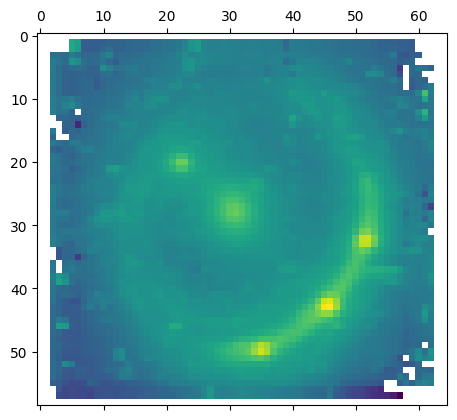

In [8]:
from matplotlib import pyplot as plt

plt.matshow(np.log10(np.nansum(data, axis=0)))

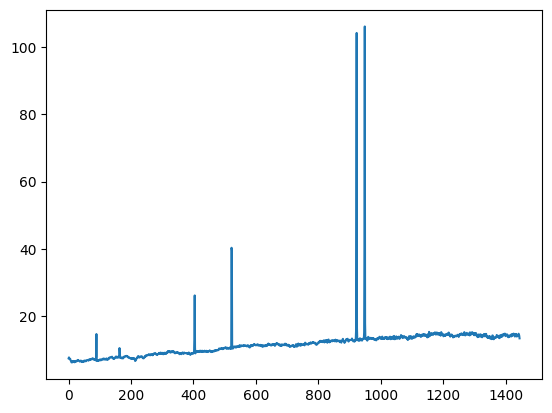

In [13]:
plt.plot(data[:, 30, 30])